# Combine u and v wind files

In [1]:
# Libraries
%load_ext autoreload
%autoreload


import numpy as np
import iris
import iris.coord_categorisation
from iris.util import unify_time_units
from iris.experimental.equalise_cubes import equalise_attributes
import iris.quickplot as qplt
# import pandas as pd

import glob
import sys
sys.path.append('../')
from libs.plot_maps import *


import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs

ImportError: 
Importing the multiarray numpy extension module failed.  Most
likely you are trying to import a failed build of numpy.
If you're working with a numpy git repo, try `git clean -xdf` (removes all
files not under version control).  Otherwise reinstall numpy.

Original error was: libopenblas.so.0: cannot open shared object file: No such file or directory


### Extracting files
Set year range of interest. Note the v and u files must be in the same directory. If you want all files in the directory, use the code commented out (it's much faster!).

In [42]:
path     = '../data/aus_wind/'
path_out = '../data/aus_wind/'
outfile = 'swnd.10m.max.'

years = range(2001, 2008)
u_files = []
v_files = []
for year in years:
    u_files.append(path + 'uwnd.10m.gauss.' + str(year) + '.nc')
    v_files.append(path + 'vwnd.10m.gauss.' + str(year) + '.nc')
    
uList = []
vList = []

# Just loading in files from 2001-3 atm. Remove [0:3] for all files
for i in u_files:
    dfu = iris.load_cube(i)
    dfu.coord('time').attributes = {}
    uList.append(dfu)
    

for j in v_files:
    dfv = iris.load_cube(j)
    dfv.coord('time').attributes = {}
    vList.append(dfv)

### For all u and v files
# u_files = glob.glob(path + 'u*.nc') # use 'recursive = True' to include subdirectories
# u_files = sorted(u_files) # sort alphabetically
# v_files = glob.glob(path + 'v*.nc') 
    
u_cube_list = iris.cube.CubeList(uList)
v_cube_list = iris.cube.CubeList(vList)

In [43]:
# # For regridding
# path_mask = '../data/climate/'
# file_mask = 'climate_mask.nc'

# mask = iris.load_cube(path_mask + file_mask)
# # mask = mask.collapsed('time', iris.analysis.MEAN)

### Set attributes

In [44]:
# Equalise attributes so they can combine
equalise_attributes(u_cube_list)
unify_time_units(u_cube_list)

equalise_attributes(v_cube_list)
unify_time_units(v_cube_list)

## Calculate wind speed

For a single year, calculate `s` which is wind speed, given by:

$s = \sqrt(u^2 + v^2)$

In [45]:
# print(s_cube_list)
# print(v_cube_list[0].data.mean)

In [46]:
# Have to load in data to do this (may take a while)
slist = v_cube_list.copy()
for year in range(len(years)):
    v_dat = v_cube_list[year].data
    u_dat = u_cube_list[year].data
    s_dat = np.sqrt((v_dat * v_dat) + (u_dat * u_dat))
    
    slist[year].data = s_dat

s_cube_list = iris.cube.CubeList(slist)

### Concatenate cubes together

In [53]:
# u = u_cube_list.concatenate_cube()
# v = v_cube_list.concatenate_cube()
s = s_cube_list.concatenate_cube()
print(s)

4xDaily v-wind at 10 m / (m/s)      (time: 10224; latitude: 94; longitude: 192)
     Dimension coordinates:
          time                           x                -              -
          latitude                       -                x              -
          longitude                      -                -              x
     Attributes:
          Conventions: COARDS
          GRIB_id: 34
          GRIB_name: V GRD
          References: http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html
          dataset: NCEP Reanalysis
          dataset_title: NCEP-NCAR Reanalysis 1
          description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables...
          least_significant_digit: 1
          level_desc: 10 m
          parent_stat: Other
          platform: Model
          precision: 2
          statistic: Individual Obs
          valid_range: [-102.2  102.2]
          var_desc: v-wind


### Plot to see it's working
This may take a while

In [54]:
def iris_plot(wind):
    dat1 = wind.collapsed('time', iris.analysis.MEAN)
    qplt.contourf(dat1)
    plt.gca().coastlines()

# iris_plot(u)

#### Take the 4 measurements per day and find the maximum wind speed. Add day time coordinate

In [55]:
# add_month, add_day_of_year, year
try:
    iris.coord_categorisation.add_month(s, 'time', name='month')
    iris.coord_categorisation.add_day_of_year(s, 'time', name='day_of_year')
    iris.coord_categorisation.add_year(s, 'time', name='year')
    print('Success')
except:
    pass

Success


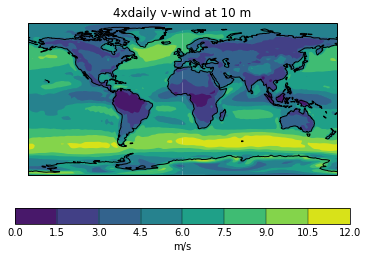

In [46]:
# iris_plot(s)

In [57]:
# Use aggregated_by instead of collapse as the latter will reduce the dimensions to a single value
# (average over all years and all months) Aggregate will clump together the timesteps with the same name

test = s.aggregated_by(['day_of_year', 'year'], iris.analysis.MAX)
swnd = test.aggregated_by(['month', 'year'], iris.analysis.MEAN) # test.aggregated_by(['month', 'year'], iris.analysis.MEAN)

In [59]:
swnd.data.mean()

7.414528742171908

### Save outputs

In [61]:
out = path_out + outfile + str(years[0]) + '-' + str(years[len(years) -1]) + '.nc'
print(out)
iris.save(swnd, out)

../data/aus_wind/swnd.10m.max.2001-2007.nc
